In [15]:
import numpy as np
import matplotlib.pyplot as plt


def f(x):
    #return #np.exp(-np.sin(2*x)**2) + np.exp(-np.cos(5*x)**2)
    return np.sin(10*x)/(5*x)

def fourier_f(x):
    return np.exp(-x**2/4)

### Implementera i MPI ###########
def dot(a, b):
    return matmat(adjoint(a), b)                # MPI: Recursive doubling

def adjoint(A):
    return A.conj().T

def matmat(A, B):
    return A @ B                                # MPI: transpose after

def outer(a, b):
    return np.outer(a, b)

def add_mult(a, b, c):
    return a + c*b
##################################

def conjgrad(x0, A, b, M):
    Ax0 = matmat(A, x0)                         # MPI: transpose Ax0 after matmat
    r = add_mult(b, Ax0, -1)                    # MPI: rank wise     
    p = r
    for m in range(M):
        Ap = matmat(A, p)                       # MPI: transpose Ap after matmat
        a = dot(r, r) / dot(p, Ap)              # MPI: recursive doubling for dot
        x0 = add_mult(x0, p, a)                 # MPI: rank wise
        r_new = add_mult(r, Ap, -a)             # MPI: rank wise
        b = dot(r_new, r_new) / dot(r, r)       # MPI: recursive doubling for dot
        r = r_new                               # MPI: rank wise
        p = add_mult(r, p, b)                   # MPI: rank wise
    return x0
    
def solve(x, fx, w, b0, regul=0.00, **kwargs):
    E = np.exp(outer(x, w)*1j)
    Ea = adjoint(E)
    A = matmat(Ea, E) + regul*np.diag((1+np.abs(w)))
    b = matmat(Ea, fx)
    return conjgrad(b0, A, b, **kwargs)


def step_mh(x, w, fx, beta, sigma, gamma, **kwargs):
    # Propoal
    noise = np.random.randn(K)
    w_new = add_mult(w, noise, sigma)
    beta_new = solve(x, fx, w_new, beta, **kwargs)
    
    # Slumpsteget
    alpha = np.random.uniform(0, 1, len(beta_new))
    proba = np.abs(beta_new / beta)**gamma
    
    # New state
    w_new = np.where(alpha < proba, w_new, w)
    beta_new = solve(x, fx, w_new, beta, **kwargs)
    
    print(f"fraction accepted: {np.sum(alpha < proba)/len(alpha):.2f}", end="\r")
    return w_new, beta_new

def eval(x, w, beta):
    return np.real(np.exp(outer(x, w)*1j) @ beta)

def mh(x,fx, sigma, gamma, num_it, **kwargs):
    w = np.random.randn(K)
    beta = solve(x, fx, w, np.zeros(K), **kwargs)
    for m in range(num_it):
        w, beta = step_mh(x, w, fx, beta, sigma, gamma, **kwargs)
    return w, beta




K = 50
N = 300


x = np.random.uniform(-3, 3, N)
fx = f(x) + 0.1*np.random.randn(N)

w = 2*np.random.randn(K)
beta = solve(x, fx, w, np.zeros(K), M=K-1)

w_1, beta_1 = mh(x, fx, sigma=1., gamma=1., num_it=4000, M=K-1)

#vilmer.strom@gmail.com

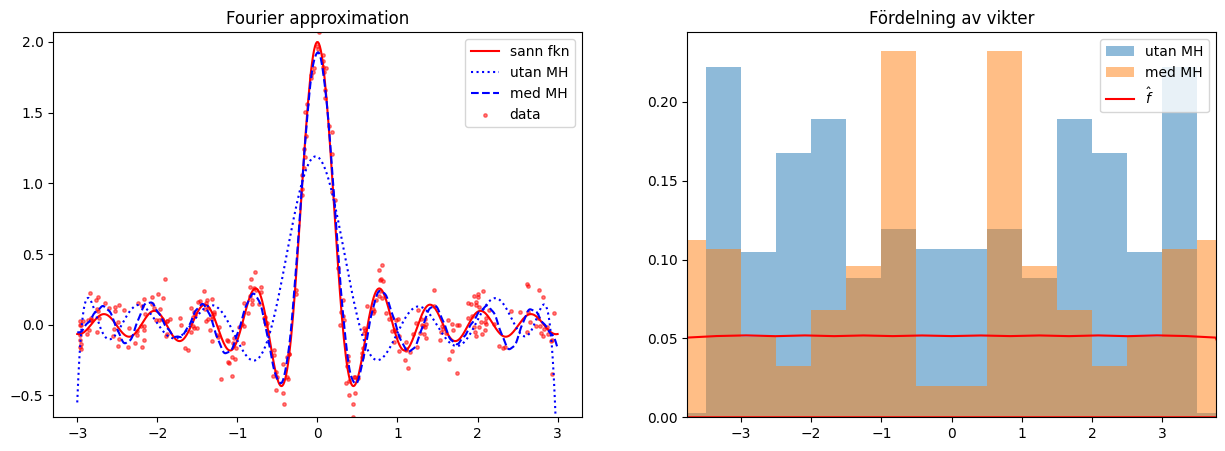

In [16]:
x_eval = np.linspace(-3, 3, 500)
f_eval = eval(x_eval, w, beta)
f_eval_1 = eval(x_eval, w_1, beta_1)



w_eval = np.linspace(-5, 5, 500)
fourier_f_eval = np.roll(np.abs(np.fft.fft(f(x_eval))), K//2)
fftfreq = np.roll(np.fft.fftfreq(len(x_eval)) / (x_eval[1] - x_eval[0])*2*np.pi, K//2)*0.4
f_density = fourier_f_eval / (np.sum(fourier_f_eval))

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title("Fourier approximation")
plt.plot(x_eval, f(x_eval), 'r-', label="sann fkn")
plt.plot(x_eval, f_eval.real, 'b:', label="utan MH")
plt.plot(x_eval, f_eval_1.real, 'b--', label="med MH")
plt.scatter(x, fx, color='red', label="data", s=6, alpha=0.5)
plt.ylim(min(fx), max(fx))
plt.legend()


def plot_hist(w, b, **kwargs):
    w = np.concatenate([w, -w])
    b = np.concatenate([b, b])
    plt.hist(w, bins=20, weights=np.abs(b), density=True, range=(-5, 5), alpha=0.5, **kwargs)

plt.subplot(122)
plt.title("Fördelning av vikter")
plot_hist(w, np.abs(beta), label="utan MH")
plot_hist(w_1, np.abs(beta_1), label="med MH")
plt.plot(fftfreq, f_density, 'r-', label="$\hat{f}$")
plt.xlim(-max(np.abs(w)), max(np.abs(w)))
plt.legend()